## Imports and Device Setting

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Check if CUDA (GPU support) is available
print(torch.cuda.is_available())

# If CUDA is available, this should print the name of the GPU (e.g., Tesla K80, T4, P100, etc.)
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU available')


True
Tesla T4


## Hyperparameters

In [ ]:
block_size = 64
batch_size = 128
max_iters = 3000
eval_iters = 100
eval_interval = 500
learning_rate = 3e-4
dropout = 0.2 # this will take out 20% of our neurons at random while training.
n_embd = 384
n_layer = 8 # NO. of Decoder Blocks
n_head = 8


## Data Loader

In [ ]:
chars = ""
with open("wizard_of_oz.txt", 'r', encoding= 'utf-8') as f:
  text = f.read()
  chars = sorted(list(set(text)))

vocab_size = len(chars)

## Encoder and Decoder

In [ ]:
string_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_string = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)


## Training and Validation Splits

In [ ]:
n = int(0.8*(len(data)))
train_data = data[:n]
val_data = data[n:]

The following function randomly selects batches of data from either the training or validation dataset, given a specified split, and creates input-output pairs for a sequence modeling task with a sliding window approach, where each input sequence (x) is of length block_size and the corresponding output sequence (y) is shifted by one token.

In [ ]:
def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))

  x = torch.stack([data[i: i + block_size] for i in ix])
  y = torch.stack([data[i+1 : i+block_size+1] for i in ix])
  x,y = x.to(device), y.to(device)
  return x,y

## Going deeper into the Block Module(each Decoder Layer)

In [ ]:
class Block(nn.Module):

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension, n_head: no. of heads we'd like:))
    super().__init__()
    head_size = n_embd // n_head # How many features are each of the heads capturing
    self.sa = MultiHeadAttention(n_head, head_size) #sa: self-attention
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd) # Layer Norm essentially helps in smoothing features out
    self.ln2 = nn.LaterNorm(n_embd)

  def forward(self,x):
    y = self.sa(x)
    x = self.ln1(x + y)
    y = self.ffwd(x)
    x = self.ln2(x + y)
    return x


In [ ]:
class FeedForward(nn.Module):
  # A simple linear layer followed by a non-linear layer, and again a linear one.
  # The inner dimensions of both the linear functions should match because they will be multiplied. So the final output weill be of (n_embd,n_embd) in size.
  def __init__(self,n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4* n_embd),
        nn.ReLU(),
        nn.Linear(4* n_embd, n_embd),
        nn.Dropout(dropout), # Certain % of our neurons stop learning. Stops overfitting:)) By becoming 0???
    )

    def forward(self,x):
      return self.net(x)


In [ ]:
class MultiHeadAttention(nn.Module):
  # Multiple heads of self-attention in parallel.

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    # Initializing a linear projection layer to combine the outputs of all heads into a single output with size 'n_embd'. Helps add the bias parameter that's learnable. The more the parameters we can train, the better. - Check!?
    self.proj = nn.Linear(head_size * num_heads, n_embd) # This will project head_size * num_heads to the n_embd. Is a common practice and helps in regularization - wtf???ALSO!!!!Like the one below!
    self.dropout = nn.Dropout(dropout) # Applying regularization - ???

  def forward(self,x):
    out = torch.cat([h(x) for h in self.heads], dim= -1) # (B,T,C) -->  (B, T, head_size * num_heads).
    out = self.dropout(self.proj(out))
    return out


**Explanation**

The "__init__" function:

- It initializes linear layers (key, query, and value) to transform the input tensor x into queries, keys, and values, respectively.

- It initializes a buffer tril containing a lower triangular matrix, which will be used to mask attention scores to prevent attending to future tokens.

The "__forward__" function:
- The parameter n_embd is the dimensionality of the embedding vectors. However, in this context, it represents the number of features in the input tensor x.

  The purpose of the linear transformations is to project the input features into different subspaces, allowing the model to learn different aspects of the input for keys, queries, and values.

- 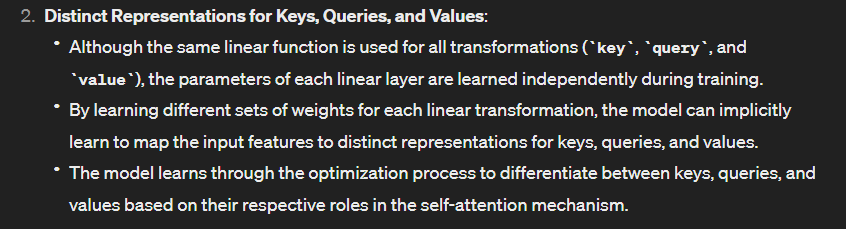


In [ ]:
class Head(nn.Module):
  """ One head of Self-Attention Only!!! """

  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias = False)
    self.query = nn.Linear(n_embd, head_size, bias = False)
    self.value = nn.Linear(n_embd, head_size, bias = False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # we register our model state instead of initializing all the above every single time every single layer

    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    # input size: (batch, time-step, channels/classes/features)
    # output size: (batch, time-step, head-size)

    B,T,C = x.shape
    k = self.key(x) # (B,T,head_size)
    q = self.query(x)
    # compute attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * k.shape[-1]** -0.5 # (B,T,head_size) @ (B,head_size, T) --> (B,T,T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B,T,T) # To prevent look-ahead:))
    wei = F.softmax(wei, dim = -1) # (B,T,T) # Sharpening our features we got from our attenion affinities. Making our model more confident about greater attention affinities!!!
    # perform the weighted aggregation of the values
    v = self.value(x) # (B,T, head_size)
    out = wei @ v # (B,T,T) @ (B,T,head_size) --> (B,T, head_size)

    return out




Standard Deviation for Model Parameters

If the numbers are far from eachother, the standard deviation will be very high. SO if you have outliers, then the network is going to face trouble in the learning process.

But if all the numbers are very close to each other and very similar, then all the neurons will learn the same patterns, and there would be no learning done.

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out



class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x



class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)


        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, index, targets=None):
        B, T = index.shape


        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)


        return logits, loss

    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

model = GPTLanguageModel(vocab_size)
# print('loading model parameters...')
# with open('model-01.pkl', 'rb') as f:
#     model = pickle.load(f)
# print('loaded successfully!')
#device = torch.device('cpu')
m = model.to(device)



Function to Estimate the Loss

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    print(iter)
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())


0
step: 0, train loss: 4.591, val loss: 4.591
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
step: 100, train loss: 3.147, val loss: 3.260
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
step: 200, train loss: 3.155, val loss: 3.279
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
24

In [ ]:
context = torch.zeros((1,1), dtype=torch.long, device = device)
generated_chars - decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)
